<a href="https://colab.research.google.com/github/bendurand/hello-world/blob/main/LabAssignmentCNNFlowers_Benjamin_Durand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/thalitadru/ml-class-epf/blob/main/LabAssignmentCNNFlowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with a CNN on the Flowers dataset

*Credits*: This notebook is based on [Tensorflow tutorial on image classification](https://www.tensorflow.org/tutorials/images/classification) (content licensed under the [Creative Commons Attribution 4.0 License](https://creativecommons.org/licenses/by/4.0/), and code samples are licensed under the [Apache 2.0 License](https://www.apache.org/licenses/LICENSE-2.0)). 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import PIL

import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(1)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**NOTE**: use the following seed throughout this noitebook:

In [ ]:
SEED = 123

# Data


## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 8s 0us/step


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


You can open an image as follows:

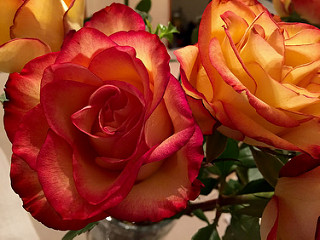

In [ ]:
# List files in a directory
roses = list(data_dir.glob('roses/*'))
# Read image with PIL
PIL.Image.open(str(roses[0]))

## TODO Open some other images
Open another rose image and one image from another class of your choice.

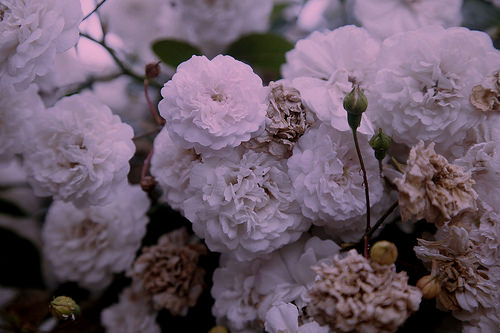

In [ ]:
PIL.Image.open(str(roses[1]))

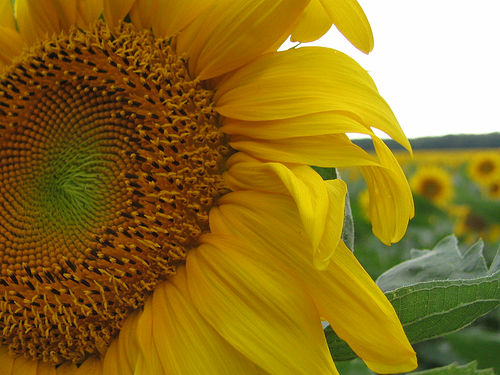

In [ ]:
sunflowers = list(data_dir.glob('sunflowers/*'))
PIL.Image.open(str(sunflowers[0]))

## Load data using a Keras utility

We will load these images off disk using the helpful [`tf.keras.utils.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) utility. 
This will take you from a directory of images on disk to a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) in just a couple lines of code. 
You can learn more about loading images into Tensorflow in the following tutorial: [Load and preprocess images](../load_data/images.ipynb).

We need to tell the loading function some paramaters:

In [ ]:
# Number of images in a batch
batch_size = 32
# The desired image size
# Images not mathcing it will be resized accordingly
img_height = 180
img_width = 180

We can also tell the loader to separate part of the images for a validation set via the argument `validation_split`, and select the split (training or validation) with `subset`. 



### TODO complete the code

- Complete the code bellow in order to used the parameters defined above. 
- Use 80% of the images for training and 20% for validation.
- Set the seed for reproducible data shuffling

**Note**: Since this datset is quite small, we will not separate a test split. When doing this, we would need to build a test set with new flower images in order to have an unbiased estimate our production performance.

Check the documentation if needed:
[`tf.keras.utils.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=SEED,
    validation_split=0.2,
    subset="training"
    )

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=SEED,
    validation_split=0.2,
    subset="validation"
    )

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## About the Dataset object

Datasets can be iterated through in `for`  loops. The dataset constructed by Keras yields a tuple object with two elements:

In [ ]:
for sample in train_ds:
    print("type:", type(sample), "lenght:", len(sample))
    break


type: <class 'tuple'> lenght: 2


The first element is a batch of images, and the second is a batch of the associated labels (as integers):

In [ ]:
for image, label in train_ds:
    print(image.shape)
    print(label.shape)
    break

(32, 180, 180, 3)
(32,)


Keras also takes into account the names of the subfolders to infer which are the text labels associated to each class. 
You can find them in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the dataset

Here are the first nine images from the training dataset:

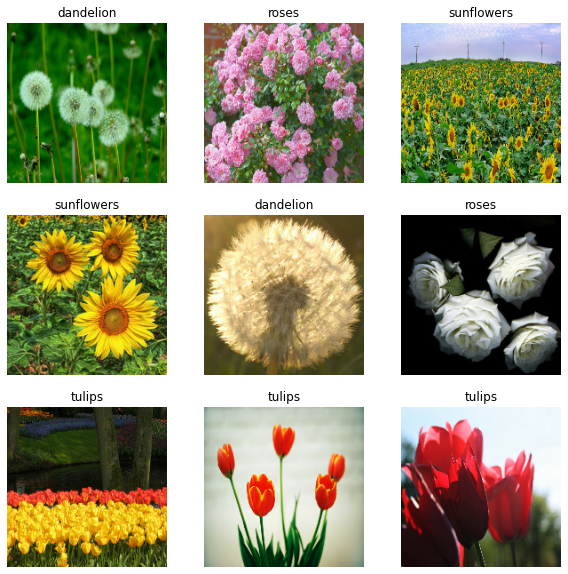

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [ ]:
for image_batch, labels_batch in train_ds:
  print("image batch shape: ", image_batch.shape)
  print("label batch shape: ", labels_batch.shape)
  break

image batch shape:  (32, 180, 180, 3)
label batch shape:  (32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Use buffered prefetching so you can yield data from disk without having I/O become blocking.
Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Normalize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will normalize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [ ]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.005711508 0.9021412


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

**Note**: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

# Model

## A basic CNN model

### TODO Create the model

Using a Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model, you will create a small convolutional network.
The model consists of:
- a preprocessing layer that rescales values by 1/255. since this is the first layer in the model, don't forget to pass it the parameter `input_shape`.
- three convolution layers ([`tf.keras.layers.Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)) 
with a max pooling layer ([`tf.keras.layers.MaxPooling2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)) after each of them;
    - Use `padding='same'` for the convolutions
    - Use ReLU activations and 3x3 kernels
    - Use an increasing number of channels: 16, 32, and 64, respectively
- a fully-connected layer (`tf.keras.layers.Dense`) with 128 units, with ReLU activation functions;
- finally an output layer with one neuron per class. 
    - Do not use the softmax activation here, as we will be computing the cross entropy loss directly from the logits.


In [ ]:
# set seed for reproducibility
tf.keras.utils.set_random_seed(SEED)

num_classes = len(class_names)

# TODO complete the list of layers
model = Sequential([
    # include preprocessing layer, along with the input shape
    layers.Rescaling(1/255, input_shape=(180,180,3)),
    # TODO complete the Conv2D calls
    layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(padding='same'),
    layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(padding='same'),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(padding='same'),
    layers.Flatten(),
    # TODO include the final Dense layers
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### TODO Compile the model

Complete the call in order to:
- use Adam optimizer
- use loss computed from logits
- include accuracy in the monitored metrics

In [ ]:
# TODO your code here
model.compile(optimizer = keras.optimizers.Adam(),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = "Accuracy")

### Monitoring callbacks


We will use some callbacks to monitor the evolution of our training:
- TensorBoard
- ModelCheckpoint
- BackupAndRestore

In [ ]:
# deirectory in which modelcheckpoints and logs are saved
LOG_DIR = 'flowers_logs'

def best_model_path(model_name):
    base_dir  = os.path.join(LOG_DIR, model_name)
    return os.path.join(base_dir, 'best_val_accuracy.ckpt')

def callback_list(model_name):
    base_dir  = os.path.join(LOG_DIR, model_name)
    tb_cb = tf.keras.callbacks.TensorBoard(base_dir)
    ckpt = tf.keras.callbacks.ModelCheckpoint(
         best_model_path(model_name),
         monitor='val_accuracy',
         mode='max', 
         verbose=0,
         save_best_only=True)
    backup_dir = os.path.join(base_dir, 'backup_checkpoint')
    bkp = tf.keras.callbacks.BackupAndRestore(
        backup_dir)
    return [tb_cb, ckpt, bkp]


### TODO Train the model

Train the model for (up to) 10 epochs with the Keras `Model.fit` method. Complete the function call bellow:

In [ ]:
MODEL_NAME = 'base_model'

In [ ]:
EPOCHS = 10
# this dictionnary will stock the logs for each model trained throughout this notebook
logs = {}

# TODO complete the fit call
logs[MODEL_NAME] = model.fit(
    train_ds,
    epochs = EPOCHS,
    validation_data = val_ds,
    callbacks=callback_list(MODEL_NAME)
)

Epoch 1/10
92/92 [==============================] - 120s 1s/step - loss: 1.4653 - Accuracy: 0.3961 - val_loss: 1.1345 - val_Accuracy: 0.5327
Epoch 2/10
92/92 [==============================] - 117s 1s/step - loss: 1.0613 - Accuracy: 0.5756 - val_loss: 1.0166 - val_Accuracy: 0.5763
Epoch 3/10
92/92 [==============================] - 119s 1s/step - loss: 0.8942 - Accuracy: 0.6475 - val_loss: 0.9247 - val_Accuracy: 0.6213
Epoch 4/10
70/92 [=====================>........] - ETA: 23s - loss: 0.7361 - Accuracy: 0.7289

## Results

TODO Launch a Tensorboard session here to monitor your learning curves. Pay attention to the ` LOG_DIR`  used in the logging calbacks, the same directory should be passed in the tensorboard call.


In [ ]:
# TODO Load the tensorboard extension
%load_ext tensorboard

In [ ]:
# TODO call tensorboard
%tensorboard --logdir ./flowers_logs


You should see that training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable — a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in deep networks. In the next exercises, you'll use *data augmentation* and add *dropout* to your model.

# Exercise: Data augmentation

Overfitting generally occurs when there are a small number of training examples.
 [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) 
 takes the approach of generating additional training data from your existing examples
  by augmenting them using random transformations that yield believable-looking images. 
 This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers:
 [`tf.keras.layers.RandomFlip`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip), 
 [`tf.keras.layers.RandomRotation`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation),
  and [`tf.keras.layers.RandomZoom`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom). 
These can be included inside your model like other layers, and run on the GPU.

### TODO Augmentation parameters
Prepare an augmentation pipline that applies the following transforms:
- Randomly flips the image horizontally
- Randomly rotates the images of $\pm$ 10% (of a full turn)
- Randomly zooms the image out by 10%

Don't forget to set the seed for these random transformations to get reproducible results.

In [ ]:
# TODO complete the code bellow
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip(mode="horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

### Visualizing augmented data

You can visualize a few augmented examples by applying data augmentation to the same image several times:

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## TODO Create new model and train it

You add data augmentation to your model and train it again. To do so, note that `Sequential` can work with a sequence of layers and/or models. You can create a new `Sequential` model combining the ` data_augmentation` pipeline and the previously declared `model`. 

Is the overfitting reduced?

In [ ]:
MODEL_NAME = 'model_augment'

### Create model

In [ ]:
model_augment = Sequential([
    # TODO complete the list of layers/models
    data_augmentation,
    # include preprocessing layer, along with the input shape
    layers.Rescaling(1/255, input_shape=(180,180,3)),
    # TODO complete the Conv2D calls
    layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(padding='same'),
    layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(padding='same'),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(padding='same'),
    layers.Flatten(),
    # TODO include the final Dense layers
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

### Compile

In [ ]:
# TODO your code here
model_augment.compile(optimizer = keras.optimizers.Adam(),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = "Accuracy")

### Train model

In [ ]:
# TODO your code here
EPOCHS = 10

logs[MODEL_NAME] = model_augment.fit(
    train_ds,
    epochs = EPOCHS,
    validation_data = val_ds,
    callbacks=callback_list(MODEL_NAME)
)

## Exercise: Dropout


Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.



### TODO Create new model and train it
- Create a new neural network with a `tf.keras.layers.Dropout` layer between the convolutionl layers and the final dense layers. Use a rate of 0.2.
- Train it again for the same number of epochs. 
- Is the overfitting reduced?

In [ ]:
MODEL_NAME = 'model_augment_dropout'

#### Create model

In [ ]:
model_augment_dropout = Sequential([
    # TODO complet with the sequence of layers/models
    data_augmentation,
    # include preprocessing layer, along with the input shape
    layers.Rescaling(1/255, input_shape=(180,180,3)),
    # TODO complete the Conv2D calls
    layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(padding='same'),
    layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(padding='same'),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(padding='same'),
    layers.Flatten(),
    layers.Dropout(0.2,seed=SEED),
    # TODO include the final Dense layers
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])


#### Compile

In [ ]:
# TODO your code here
model_augment.compile(optimizer = keras.optimizers.Adam(),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = "Accuracy")

#### Training model with dropout

In [ ]:
EPOCHS = 10
# TODO your code here
logs[MODEL_NAME] = model_augment_dropout.fit(
  train_ds,
  epochs = EPOCHS,
  validation_data = val_ds,
  callbacks=callback_list(MODEL_NAME)
)

# Results summary
Here we gather the logs of all 3 models and plot them together:

In [ ]:
# for each log, get history
for k, v in logs.items():
    logs[k] = v.history

In [ ]:
# create a flatened dictionnary out of the nested one
flat_dict = {}
for model, history in logs.items():
    for metric, curve in history.items():
        flat_dict[(metric, model)] = curve
# use it to create a multi-index column dataframe
logs_df = pd.DataFrame(flat_dict)
logs_df.columns.set_names(['metric', 'model'])
logs_df

In [ ]:
# Plots
fig, (ax0,ax1) = plt.subplots(2, 1, sharex=True, figsize=(16,8))
logs_df[['accuracy','val_accuracy']].plot(ax=ax0)
logs_df[['loss','val_loss']].plot(ax=ax1)
ax0.set_xlabel('epochs')
ax1.set_xlabel('epochs')
fig.tight_layout()

# Conclusion

What can you conclude about the three models tested? Which one seems the best candidate for further developments?

# Extra: transfer learning

Following the transfer learning tutorial, load a pretrained model from `tf.keras.applications` and apply it to the flowers data:
- First, freeze the pre-trained model and train a new classification head on top of it. How well does it perform?
- Then, un-freeze the pre-trained model and fine-une it using a lower learning rate. How well does it perform?